# Expected goals - Creating the XG model

Date : 21/03/2021

Author : Chloe GOBÉ

This code is presented with two JupyterNotebooks (Step 1 et Step 2)

Functions that I have not written myself are in FriendOfTracking.py and have been written by Laurie Shaw. 
The functions written for this challenge can be found in Functions_Step1.py

## Set up & Data Exploration

In [1]:
# Import librairies

## Functions
import Functions_Step_1 as func

## Data wrangling
import pandas as pd
import numpy as np

## Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Arc

# Machine Learning
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import average_precision_score, brier_score_loss, f1_score

# Save model
import pickle

In [2]:
# Import data and show some basic info
shots = pd.read_csv("ShotData.csv")
print(shots.info())
shots.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10925 entries, 0 to 10924
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   match_minute                  10925 non-null  int64  
 1   match_second                  10925 non-null  int64  
 2   position_x                    10925 non-null  float64
 3   position_y                    10925 non-null  float64
 4   play_type                     10925 non-null  object 
 5   BodyPart                      10925 non-null  object 
 6   Number_Intervening_Opponents  10925 non-null  int64  
 7   Number_Intervening_Teammates  10925 non-null  int64  
 8   Interference_on_Shooter       10882 non-null  object 
 9   outcome                       10925 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 853.6+ KB
None


,match_minute,match_second,position_x,position_y,play_type,BodyPart,Number_Intervening_Opponents,Number_Intervening_Teammates,Interference_on_Shooter,outcome
0,7,24,3.24,-0.75,Open Play,Head,1,0,Low,Goal
1,34,55,24.94,0.75,Open Play,Left,3,0,Medium,Missed
2,60,33,3.74,-0.50,Open Play,Right,1,0,Low,Missed
3,68,42,21.45,-8.48,Direct freekick,Left,4,2,Low,Blocked
4,18,0,10.23,4.99,Open Play,Head,1,0,Low,Missed


## Data transformation

### Basic changes

In [ ]:
# I remove the shots that led to owngoals as they are not really predictable
df_shots = shots[shots["outcome"] != "owngoal"]

# Part the shots in two classes : the shots that led to a goal and the others
df_shots["Goal"] = df_shots.loc[:, "outcome"].apply(lambda x: 1 if x == "Goal" else 0)

In [ ]:
# As we don't know if the shot-taker is left-footed or right-footed, 
# I gather left and right foot in a "Foot" value
dict_map = {
    "Right" : "Foot",
    "Left" : "Foot",
    "Head" : "Head"
    ,"Other" : "Other"
}
df_shots["BodyPart"] = df_shots.loc[:,"BodyPart"].map(dict_map)


# A direct corner is similar to a direct freekick and they are too scarce in the dataset to be studied separately
dict_map = {
    'Open Play' : 'Open Play',
    "Penalty" : "Penalty",
    "Direct freekick" : "Direct freekick",
    "Direct Corner" : "Direct freekick",
    "Direct corner" : "Direct freekick"
}
df_shots["play_type"] = df_shots.loc[:,"play_type"].map(dict_map)

### Adding two variables : shot distance and shot angle

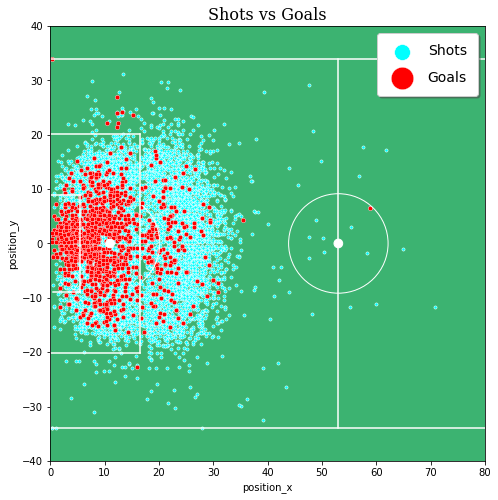

In [6]:
# Create Pitch
fig, ax = func.create_pitch()

# Plot the shots and goals of the dataset
sns.scatterplot(data=df_shots, x="position_x", y="position_y", 
                s=10, color="cyan", edgecolor='white', linewidth=0.5, label="Shots", ax=ax)
sns.scatterplot(data=df_shots[df_shots["Goal"] == 1], x="position_x", y="position_y", 
                s=20, color="red", label="Goals", ax=ax)

# Format
plt.legend(loc='upper right',fontsize=14, markerscale=5,borderpad=0.8, labelspacing=0.9,shadow=True)
ax.set_title('Shots vs Goals', fontsize=16, fontfamily="serif")
plt.xlim((0,80))
plt.ylim((-40,40))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


We now create 2 variables that are more representative of the situation that the coordinates of the shots :

- the distance between the shot and the center of the opponents' goal frame
- the shot angle, the angle between the shot-taker and the goal posts

In [11]:
# Calculate the variables from the coordinates
df_shots["ShotAngle"] = df_shots.apply(
    lambda row: func.shot_angle(row["position_x"], row["position_y"]), axis=1)

df_shots["DistanceToGoal"] = df_shots.apply(
    lambda row: func.distance_goal(row["position_x"], row["position_y"]), axis=1)

df_shots.head()

,match_minute,match_second,position_x,position_y,play_type,BodyPart,Number_Intervening_Opponents,Number_Intervening_Teammates,Interference_on_Shooter,outcome,Goal,ShotAngle,DistanceToGoal
0,7,24,3.24,-0.75,Open Play,Head,1,0,Low,Goal,1,1.668954,3.325673
1,34,55,24.94,0.75,Open Play,Foot,3,0,Medium,Missed,0,0.291170,24.951275
2,60,33,3.74,-0.50,Open Play,Foot,1,0,Low,Missed,0,1.540050,3.773274
3,68,42,21.45,-8.48,Direct freekick,Foot,4,2,Low,Blocked,0,0.293982,23.065405
4,18,0,10.23,4.99,Open Play,Head,1,0,Low,Missed,0,0.572622,11.382135


Let's now plot some of these data to see if they are correlated with goals

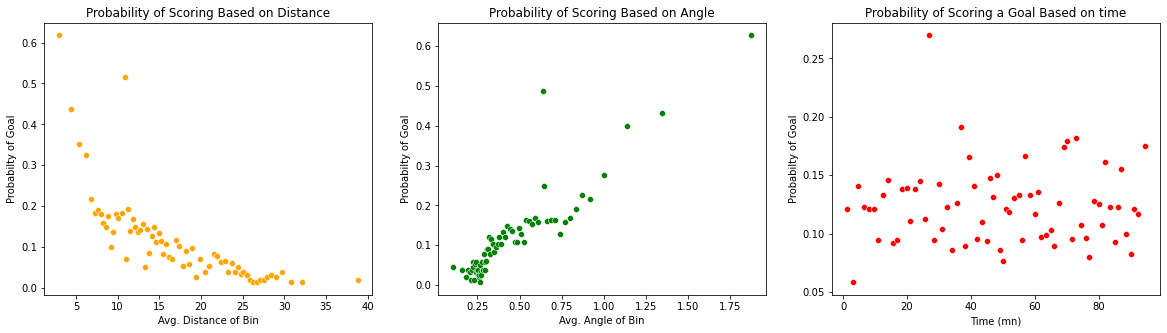

In [12]:
# Plot the Shot Distance and the Angle of Shot
# Inspiration : Friends of Tracking - David Sumpter

fig, axes = plt.subplots(1, 3,figsize=(20,5))
df_shots['Distance_Bins'] = pd.qcut(df_shots['DistanceToGoal'],q=70)

#now we want to find the mean of the Goal column (our prob density) for each bin
#and the mean of the distance for each bin
dist_prob = df_shots.groupby('Distance_Bins',as_index=False)['Goal'].mean()['Goal']
dist_mean = df_shots.groupby('Distance_Bins',as_index=False)['DistanceToGoal'].mean()['DistanceToGoal']
dist_trend = sns.scatterplot(x=dist_mean,y=dist_prob,ax=axes[0], color="orange")
dist_trend.set(xlabel="Avg. Distance of Bin",
       ylabel="Probabilty of Goal",
       title="Probability of Scoring Based on Distance")

#same for the angle
df_shots['Angle_Bins'] = pd.qcut(df_shots['ShotAngle'],q=70)
angle_prob = df_shots.groupby('Angle_Bins',as_index=False)['Goal'].mean()['Goal']
angle_mean = df_shots.groupby('Angle_Bins',as_index=False)['ShotAngle'].mean()['ShotAngle']
angle_trend = sns.scatterplot(x=angle_mean,y=angle_prob,ax=axes[1], color="green")
angle_trend.set(xlabel="Avg. Angle of Bin",
       ylabel="Probabilty of Goal",
       title="Probability of Scoring Based on Angle")

#same for the time
df_shots['Goal']=df_shots['Goal'].astype(int)
df_shots['Minutes_BINS'] = pd.qcut(df_shots['match_minute'],q=70)

dist_prob = df_shots.groupby('Minutes_BINS',as_index=False)['Goal'].mean()['Goal']
dist_mean = df_shots.groupby('Minutes_BINS',as_index=False)['match_minute'].mean()['match_minute']
dist_trend = sns.scatterplot(x=dist_mean,y=dist_prob, color="red")
dist_trend.set(xlabel="Time (mn)",
       ylabel="Probabilty of Goal",
       title="Probability of Scoring a Goal Based on time")
dis = np.linspace(0,50,100)
plt.show()

We can see that the distance to the goal and the angle are two important variables to see a shot transformed in goal.
But the time (minutes or seconds) is not correlated with the probability of scoring.
We will put this variable aside for the chance quality model

### Categorical variables for the model

The model I am going to use does not deal with categorical values

In [13]:
# I want to keep the gradation level of the interference
dict_map = {"High" : 3, "Medium" : 2, "Low" : 1}
df_shots["Pressure"] = df_shots["Interference_on_Shooter"].map(dict_map)

In [14]:
# Transform the BodyPart and The Play Type in binary values
df_shots = pd.get_dummies(df_shots, columns=["BodyPart", "play_type"])

## Building a model

In [15]:
# Create a dataframe with the variables that are going to be used
df_model = df_shots[["DistanceToGoal","ShotAngle",
"Number_Intervening_Opponents","Pressure",
"BodyPart_Foot","BodyPart_Head", "BodyPart_Other",
"play_type_Direct freekick", "play_type_Open Play", "play_type_Penalty",
"Goal"]]

In [16]:
X = df_model.iloc[:,:-1] # The features
y = df_model.iloc[:,-1] # The target

# Split the dataset in train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

print('The test set contains {} examples (shots) of which {} are positive (goals).'.format(len(y_test), y_test.sum()))

The test set contains 2721 examples (shots) of which 331 are positive (goals).


I choose 3 metrics to evalute the models :

- Brier Score Loss : because we care more about the precision of the probabilities than the predictions of the classes in itself
- PR-AUC : the dataset is imbalanced and we care mostly about the positive score (Goal =1)
- F1-score : because we care mostly about the positive class (Goal = 1) as an alternative of the PR-AUC

### Dummy classifer

In [17]:
# Let's classify the model with a Dummy Classifier for future comparaison
clf = DummyClassifier(strategy="stratified", random_state=42).fit(X_train,y_train)

print('The dummy classifier obtains a Brier score loss of {}'.format(round(brier_score_loss(y_test, clf.predict_proba(X_test)[:,1]),4)))
print('Our dummy classifier obtains an PR-AUC of {}%.'.format(round(average_precision_score(y_test, clf.predict_proba(X_test)[:, 1])*100,2)))
print('Our dummy classifier obtains a F1-score of {}%.'.format(round(f1_score(y_test, clf.predict(X_test))*100,2)))


The dummy classifier obtains a Brier score loss of 0.2121
Our dummy classifier obtains an PR-AUC of 12.18%.
Our dummy classifier obtains a F1-score of 12.18%.


### Logistic Regression

A quick benchmark of the "expected goal" models available on Internet and the shape of the P(Goal | Distance, Angle) lead to try a Logistic Regression classifier

#### GridSearch

In [18]:
# Apply a GridSearch for finding the best parameters to minimize The Brier Score
grid_logreg = GridSearchCV(
    estimator = LogisticRegression(max_iter=1000, random_state=42), 
    param_grid = {'C':np.logspace(-3, 3, 30)}, 
    cv=3,
    scoring = 'neg_brier_score')

grid_logreg.fit(X_train, y_train);

In [19]:
# Compute the metrics to compare with the dummy classifier
print('The LogReg classifier obtains a Brier score loss of {}'.format(round(brier_score_loss(y_test, grid_logreg.predict_proba(X_test)[:,1]),4)))
print('Our LogReg classifier obtains an PR-AUC of {}%.'.format(round(average_precision_score(y_test, grid_logreg.predict_proba(X_test)[:, 1])*100,2)))
print('Our LogReg classifier obtains a F1-score of {}%.'.format(round(f1_score(y_test, grid_logreg.predict(X_test))*100,2)))

The LogReg classifier obtains a Brier score loss of 0.0857
Our LogReg classifier obtains an PR-AUC of 44.36%.
Our LogReg classifier obtains a F1-score of 30.26%.


We can see a significative improvement of the model compare to a dummy classifier

#### Importance of features

In [20]:
results = dict()
for features, weight in list(zip(X_train.columns, grid_logreg.best_estimator_.coef_[0])):
    results[features] = weight

pd.DataFrame.from_dict(results, orient="index", columns=["Coefficients"]
                      ).sort_values(by="Coefficients", key=abs, ascending=False)

,Coefficients
play_type_Open Play,-1.185815
ShotAngle,0.846005
play_type_Penalty,0.778491
Pressure,-0.478957
BodyPart_Foot,0.453905
play_type_Direct freekick,0.406720
BodyPart_Head,-0.400493
Number_Intervening_Opponents,-0.301296
DistanceToGoal,-0.103527
BodyPart_Other,-0.054016


#### Representation of the probabilities to score

- 0 Intervening Opponents
- Low interference
- Open Play
- Shot taken with the foot

In [21]:
#Create a 2D map of xG
pgoal_2d = np.zeros((80,80))
for x in range(0,80):
    for y in range(0,80):
        pgoal_2d[y,x] =  func.calculate_xg(x,y-40, grid_logreg)

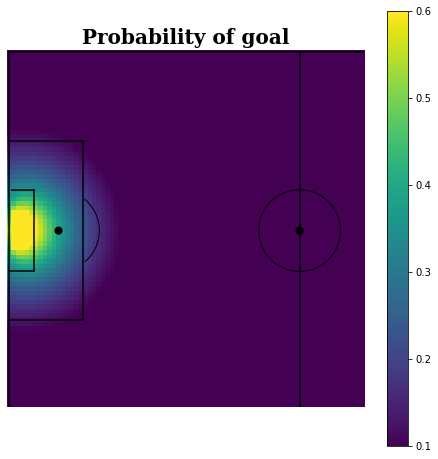

In [43]:
fig, ax = plt.subplots(figsize=(8,8))

#Pitch Outline & Centre Line
plt.plot([0,0],[80,0], color="black")
plt.plot([0,80],[80,80], color="black")
plt.plot([80,80],[80,0], "--", color="black")
plt.plot([80,0],[0,0], color="black")
plt.plot([65,65],[0,80], color="black")

#Left Penalty Area
plt.plot([16.5,16.5],[60,20],color="black")
plt.plot([0,16.5],[60,60],color="black")
plt.plot([16.5,0],[20,20],color="black")

#Left 6-yard Box
plt.plot([0,5.5],[49,49],color="black")
plt.plot([5.5,5.5],[49,31],color="black")
plt.plot([5.5,0.5],[31,31],color="black")

#Prepare Circles
centreCircle = plt.Circle((65,40),9.15,color="black",fill=False)
centreSpot = plt.Circle((65,40),0.8,color="black")
leftPenSpot = plt.Circle((11,40),0.8,color="black")

#Draw Circles
ax.add_patch(centreCircle)
ax.add_patch(centreSpot)
ax.add_patch(leftPenSpot)

#Prepare Arcs
leftArc = Arc((11,40),height=18.3,width=18.3,angle=0,theta1=310,theta2=50,color="black")
ax.add_patch(leftArc)
pos=ax.imshow(pgoal_2d, vmin=0.1, vmax=0.6) # [0.1, 0.6] is chosen to display the half-circle shape

fig.colorbar(pos, ax=ax)
ax.set_title('Probability of goal', fontsize=20, fontfamily="serif", fontweight="bold")
plt.axis('off')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [44]:
pkl_filename = "pickle_logreg_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(grid_logreg, file)